In [13]:
#classes = hp['classes']

import pandas as pd
#import xlrd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.impute import KNNImputer
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
pd.DataFrame.iteritems=pd.DataFrame.items
tf.compat.v1.disable_v2_behavior()
# change the strings to ints
#input= pd.DataFrame(pd.read_csv("US Insurance Claims Data.xlsx", encoding='utf-16-le', encoding_errors='ignore'))


In [14]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Load data
df = pd.read_excel("US_Insurance_Claims_Data.xlsx")

# Step 1: Separate datetime columns
datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
df_datetime = df[datetime_cols]

# Step 2: Exclude datetime columns for KNN imputation
df_knn = df.drop(columns=datetime_cols).copy()

# Step 3: Label encode categorical columns
label_encoders = {}
for col in df_knn.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_knn[col] = le.fit_transform(df_knn[col].astype(str))
    label_encoders[col] = le

# Step 4: Apply KNN imputer
imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(imputer.fit_transform(df_knn), columns=df_knn.columns)

# Step 5: Round integer columns
for col in df_knn.select_dtypes(include='int64').columns:
    df_knn_imputed[col] = df_knn_imputed[col].round().astype(int)

# Step 6: Reverse label encoding
for col, le in label_encoders.items():
    df_knn_imputed[col] = df_knn_imputed[col].round().astype(int)
    df_knn_imputed[col] = le.inverse_transform(df_knn_imputed[col])

# Step 7: Reattach datetime columns
df_cleaned = pd.concat([df_knn_imputed, df_datetime.reset_index(drop=True)], axis=1)

# Step 8: Final check
print("Missing values after KNN imputation:", df_cleaned.isnull().sum().sum())

# Optional: Save result
df_cleaned.to_csv("US_Insurance_KNN_Imputed.csv", index=False)
input=pd.read_csv("US_Insurance_KNN_Imputed.csv")
input=input.fillna(method='bfill').fillna(method='ffill')

Missing values after KNN imputation: 0


/var/folders/ql/5nmrkn3145n9_pzr7h7w7_gh0000gn/T/ipykernel_54300/3358762314.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  input=input.fillna(method='bfill').fillna(method='ffill')


In [15]:
input.incident_location=input.incident_location.astype('category').cat.codes
input.policy_state=input.policy_state.astype('category').cat.codes
input.insured_education_level=input.insured_education_level.astype('category').cat.codes
input.insured_sex=input.insured_sex.astype('category').cat.codes
input.insured_hobbies=input.insured_hobbies.astype('category').cat.codes
input.insured_relationship=input.insured_relationship.astype('category').cat.codes
input.incident_type=input.incident_type.astype('category').cat.codes
input.collision_type=input.collision_type.astype('category').cat.codes
input.incident_severity=input.incident_severity.astype('category').cat.codes
input.authorities_contacted=input.authorities_contacted.astype('category').cat.codes
input.incident_state=input.incident_state.astype('category').cat.codes
input.incident_city=input.incident_city.astype('category').cat.codes
input.insured_occupation=input.insured_occupation.astype('category').cat.codes
input.property_damage=input.property_damage.astype('category').cat.codes
input.police_report_available=input.police_report_available.astype('category').cat.codes
input.auto_make=input.auto_make.astype('category').cat.codes
input.auto_model=input.auto_model.astype('category').cat.codes
#input['fraud_reported']=input['fraud_reported'].fillna(method='ffill').fillna(method='bfill')
input.fraud_reported=input.fraud_reported.astype('category').cat.codes
input.incident_date=input.incident_date.astype('category').cat.codes
input.policy_bind_date=input.incident_date.astype('category').cat.codes
input['policy_csl'] = input['policy_csl'].apply(lambda x: eval(x))

In [16]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.keras.preprocessing.sequence import pad_sequences

#trainX_padded = pad_sequences(trainX, padding='post', truncating='post')
#testX_padded = pad_sequences(testX, padding='post', truncating='post')
#trainY_padded = pad_sequences(trainY, padding='post', truncating='post')
#testY_padded = pad_sequences(testY, padding='post', truncating='post')



grouped = input.groupby('months_as_customer')

# Extract sequences and labels
sequences = grouped.apply(lambda X: X[['months_as_customer', 'age', 'policy_number', 'policy_bind_date' , 'policy_state', 'policy_csl', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital-gains', 'capital-loss', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make', 'auto_model', 'auto_year']].values.tolist())
labels = grouped['fraud_reported'].first().values
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad to same length (post-padding with zeros)
X = pad_sequences(sequences.tolist(), padding='post', dtype='float32')
y = np.array(labels)
# Flatten time dimension to create 2D array for VIF calculation
# Shape: (samples * timesteps, features)
X_2d_for_vif = X.reshape(-1, X.shape[2])

def calculate_vif_3d(X_2d, thresh=5.0):
    print("Calculating VIF for each feature (collapsed over timesteps)...")
    variables = list(range(X_2d.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X_2d[:, variables], ix) for ix in range(len(variables))]
        max_vif = max(vif)
        if max_vif > thresh:
            maxloc = vif.index(max_vif)
            print(f"Dropping feature at index {variables[maxloc]} with VIF={max_vif:.2f}")
            variables.pop(maxloc)
            dropped = True
    return variables

# Calculate VIF and get list of features to keep
features_to_keep = calculate_vif_3d(X_2d_for_vif, thresh=10.0)

print(f"Selected {len(features_to_keep)} features out of {X.shape[2]} based on VIF")

# Filter original X on feature dimension (3rd dimension)
X_filtered = X[:, :, features_to_keep]

# Now flatten for SMOTE and undersampling (samples, timesteps*features_kept)
X_flat = X_filtered.reshape(X_filtered.shape[0], -1)

smote = SMOTE(sampling_strategy=0.8, random_state=42)
#rus = RandomUnderSampler(random_state=1000)

# Apply SMOTE then undersampling
X_resampled, y_resampled = smote.fit_resample(X_flat, y)
#X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

timesteps = X_filtered.shape[1]
features_kept = X_filtered.shape[2]

X_resampled = X_resampled.reshape(-1, timesteps, features_kept)

#print(f"Original shape: {X.shape}")
#print(f"Filtered shape (after VIF): {X_filtered.shape}")
#print(f"Resampled shape: {X_resampled_3d.shape}")
#print(f"Original class distribution: {np.bincount(y)}")
#print(f"Resampled class distribution: {np.bincount(y_resampled)}")

# X_resampled_3d, y_resampled are now ready for your sequential model


Calculating VIF for each feature (collapsed over timesteps)...
Dropping feature at index 3 with VIF=1576338686514.00
Dropping feature at index 31 with VIF=6543.02
Dropping feature at index 37 with VIF=226.42
Dropping feature at index 1 with VIF=107.59
Dropping feature at index 9 with VIF=38.70
Dropping feature at index 5 with VIF=27.07
Dropping feature at index 7 with VIF=22.99
Dropping feature at index 34 with VIF=18.26
Dropping feature at index 26 with VIF=13.62
Selected 29 features out of 38 based on VIF



📂 Fold 1/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-04 13:39:08.858640: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_121/Assign' id:82414 op device:{requested: '', assigned: ''} def:{{{node false_positives_121/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_121, false_positives_121/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 13:39:16.638622: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_64/mul' id:82685 op device:{requested: '', assigned: ''} def:{{{

🔍 Calculating SHAP values for fold 1 of 'Convex Only'

📂 Fold 2/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-04 13:47:19.750528: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_207/kernel/Assign' id:84288 op device:{requested: '', assigned: ''} def:{{{node dense_207/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_207/kernel, dense_207/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 13:47:27.764992: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_66/mul' id:84646 op device:{requested: '', assigned: ''} def:{{{nod


📂 Fold 3/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-04 13:55:19.575818: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_187/Assign' id:85836 op device:{requested: '', assigned: ''} def:{{{node true_positives_187/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_187, true_positives_187/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 13:55:27.989601: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_67/mul' id:86127 op device:{requested: '', assigned: ''} def:{{{node


📂 Fold 4/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-04 14:04:11.314688: W tensorflow/c/c_api.cc:305] Operation '{name:'training_126/Adam/iter/Assign' id:88158 op device:{requested: '', assigned: ''} def:{{{node training_126/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_126/Adam/iter, training_126/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 14:04:19.445988: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_68/mul' id:87608 op device:{requested: '', assigned:


📂 Fold 5/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-04 14:12:39.037410: W tensorflow/c/c_api.cc:305] Operation '{name:'training_128/Adam/dense_222/bias/m/Assign' id:89709 op device:{requested: '', assigned: ''} def:{{{node training_128/Adam/dense_222/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_128/Adam/dense_222/bias/m, training_128/Adam/dense_222/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 14:12:47.592895: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_69/m


📂 Fold 6/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-04 14:21:34.201180: W tensorflow/c/c_api.cc:305] Operation '{name:'training_130/Adam/dense_228/bias/v/Assign' id:91279 op device:{requested: '', assigned: ''} def:{{{node training_130/Adam/dense_228/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_130/Adam/dense_228/bias/v, training_130/Adam/dense_228/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 14:21:42.625106: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_70/m


📂 Fold 7/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-04 14:29:46.442544: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_199/Assign' id:91760 op device:{requested: '', assigned: ''} def:{{{node true_positives_199/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_199, true_positives_199/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 14:29:55.043467: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_71/mul' id:92051 op device:{requested: '', assigned: ''} def:{{{node


📂 Fold 8/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-04 14:38:27.756121: W tensorflow/c/c_api.cc:305] Operation '{name:'lstm_47/lstm_cell/bias/Assign' id:92968 op device:{requested: '', assigned: ''} def:{{{node lstm_47/lstm_cell/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_47/lstm_cell/bias, lstm_47/lstm_cell/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 14:38:36.459071: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_72/mul' id:93532 op device:{requested: '', assigned


📂 Fold 9/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-04 14:47:13.481807: W tensorflow/c/c_api.cc:305] Operation '{name:'training_136/Adam/dense_242/kernel/v/Assign' id:95705 op device:{requested: '', assigned: ''} def:{{{node training_136/Adam/dense_242/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_136/Adam/dense_242/kernel/v, training_136/Adam/dense_242/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 14:47:22.801898: W tensorflow/c/c_api.cc:305] Operation '{name:'l


📂 Fold 10/10

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-12-04 15:32:21.771009: W tensorflow/c/c_api.cc:305] Operation '{name:'false_negatives_139/Assign' id:96228 op device:{requested: '', assigned: ''} def:{{{node false_negatives_139/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_139, false_negatives_139/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 15:32:34.283201: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_74/mul' id:96494 op device:{requested: '', assigned: ''} def:{{{


📊 Average metrics for schedule 'Convex Only': {'loss': 0.06923235606909357, 'accuracy': 0.5730243, 'precision': 0.6688889, 'recall': 0.085477695, 'f1': 0.1445256898628491, 'auc': 0.5316949948305891}

📂 Fold 1/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-04 15:50:52.483238: W tensorflow/c/c_api.cc:305] Operation '{name:'training_140/Adam/iter/Assign' id:98525 op device:{requested: '', assigned: ''} def:{{{node training_140/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_140/Adam/iter, training_140/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 15:51:05.616193: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_75/mul' id:97975 op device:{requested: '', assigned:


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-04 15:52:10.279283: W tensorflow/c/c_api.cc:305] Operation '{name:'true_negatives_71/Assign' id:98873 op device:{requested: '', assigned: ''} def:{{{node true_negatives_71/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_negatives_71, true_negatives_71/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 15:52:23.370489: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_76/mul' id:99154 op device:{requested: '', assigned: ''} def:{{{node loss_76/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_76/mul/x, loss_76/dense_254_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after runnin


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 15:56:52.820665: W tensorflow/c/c_api.cc:305] Operation '{name:'true_negatives_72/Assign' id:99875 op device:{requested: '', assigned: ''} def:{{{node true_negatives_72/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_negatives_72, true_negatives_72/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 15:57:05.812875: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_77/mul' id:100156 op device:{requested: '', assigned: ''} def:{{{node loss_77/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_77/mul/x, loss_77/dense_254_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after runni

🔍 Calculating SHAP values for fold 1 of 'Multistage_1'

📂 Fold 2/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-04 16:02:51.577206: W tensorflow/c/c_api.cc:305] Operation '{name:'training_146/Adam/lstm_51/lstm_cell/recurrent_kernel/v/Assign' id:102601 op device:{requested: '', assigned: ''} def:{{{node training_146/Adam/lstm_51/lstm_cell/recurrent_kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_146/Adam/lstm_51/lstm_cell/recurrent_kernel/v, training_146/Adam/lstm_51/lstm_cell/recurrent_kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
202


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-04 16:04:10.200088: W tensorflow/c/c_api.cc:305] Operation '{name:'true_negatives_74/Assign' id:102843 op device:{requested: '', assigned: ''} def:{{{node true_negatives_74/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_negatives_74, true_negatives_74/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 16:04:24.017203: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_80/mul' id:103124 op device:{requested: '', assigned: ''} def:{{{node loss_80/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_80/mul/x, loss_80/dense_259_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after runn


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 16:08:56.368290: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_226/Assign' id:103830 op device:{requested: '', assigned: ''} def:{{{node true_positives_226/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_226, true_positives_226/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 16:09:09.806228: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_81/mul' id:104126 op device:{requested: '', assigned: ''} def:{{{node loss_81/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_81/mul/x, loss_81/dense_259_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after 


📂 Fold 3/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-04 16:14:48.940664: W tensorflow/c/c_api.cc:305] Operation '{name:'training_152/Adam/dense_260/kernel/v/Assign' id:106098 op device:{requested: '', assigned: ''} def:{{{node training_152/Adam/dense_260/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_152/Adam/dense_260/kernel/v, training_152/Adam/dense_260/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 16:15:02.199979: W tensorflow/c/c_api.cc:305] Operation '{name:'


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-04 16:16:06.625852: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_154/Assign' id:106308 op device:{requested: '', assigned: ''} def:{{{node false_positives_154/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_154, false_positives_154/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 16:16:20.404340: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_83/mul' id:106609 op device:{requested: '', assigned: ''} def:{{{node loss_83/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_83/mul/x, loss_83/dense_264_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes af


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 16:20:42.090203: W tensorflow/c/c_api.cc:305] Operation '{name:'false_negatives_156/Assign' id:107320 op device:{requested: '', assigned: ''} def:{{{node false_negatives_156/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_156, false_negatives_156/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 16:20:55.931080: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_84/mul' id:107611 op device:{requested: '', assigned: ''} def:{{{node loss_84/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_84/mul/x, loss_84/dense_264_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes af


📂 Fold 4/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-04 16:26:32.425951: W tensorflow/c/c_api.cc:305] Operation '{name:'lstm_53/lstm_cell/kernel/Assign' id:108322 op device:{requested: '', assigned: ''} def:{{{node lstm_53/lstm_cell/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_53/lstm_cell/kernel, lstm_53/lstm_cell/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 16:26:46.227615: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_85/mul' id:108915 op device:{reque


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-04 16:27:49.875487: W tensorflow/c/c_api.cc:305] Operation '{name:'false_negatives_160/Assign' id:109803 op device:{requested: '', assigned: ''} def:{{{node false_negatives_160/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_160, false_negatives_160/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 16:28:03.624602: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_86/mul' id:110094 op device:{requested: '', assigned: ''} def:{{{node loss_86/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_86/mul/x, loss_86/dense_269_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes af


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 16:32:36.608385: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_163/Assign' id:110820 op device:{requested: '', assigned: ''} def:{{{node false_positives_163/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_163, false_positives_163/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 16:32:50.437277: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_87/mul' id:111096 op device:{requested: '', assigned: ''} def:{{{node loss_87/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_87/mul/x, loss_87/dense_269_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes af


📂 Fold 5/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-04 16:38:28.728397: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_274/kernel/Assign' id:112084 op device:{requested: '', assigned: ''} def:{{{node dense_274/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_274/kernel, dense_274/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 16:38:42.808899: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_88/mul' id:112400 op device:{requested: '', assigned: ''} def:{{{n


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-04 16:39:47.989373: W tensorflow/c/c_api.cc:305] Operation '{name:'false_negatives_166/Assign' id:113288 op device:{requested: '', assigned: ''} def:{{{node false_negatives_166/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_166, false_negatives_166/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 16:40:02.248248: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_89/mul' id:113579 op device:{requested: '', assigned: ''} def:{{{node loss_89/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_89/mul/x, loss_89/dense_274_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes af


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 16:44:24.205914: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_254/Assign' id:114295 op device:{requested: '', assigned: ''} def:{{{node true_positives_254/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_254, true_positives_254/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 16:44:38.864727: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_90/mul' id:114581 op device:{requested: '', assigned: ''} def:{{{node loss_90/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_90/mul/x, loss_90/dense_274_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after 


📂 Fold 6/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-04 16:50:21.301821: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_279/kernel/Assign' id:115569 op device:{requested: '', assigned: ''} def:{{{node dense_279/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_279/kernel, dense_279/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 16:50:34.420421: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_91/mul' id:115885 op device:{requested: '', assigned: ''} def:{{{n


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-04 16:51:43.901703: W tensorflow/c/c_api.cc:305] Operation '{name:'count_86/Assign' id:116804 op device:{requested: '', assigned: ''} def:{{{node count_86/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_86, count_86/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 16:51:57.389693: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_92/mul' id:117064 op device:{requested: '', assigned: ''} def:{{{node loss_92/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_92/mul/x, loss_92/dense_279_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 16:56:40.388172: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_175/Assign' id:117790 op device:{requested: '', assigned: ''} def:{{{node false_positives_175/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_175, false_positives_175/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 16:56:54.665608: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_93/mul' id:118066 op device:{requested: '', assigned: ''} def:{{{node loss_93/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_93/mul/x, loss_93/dense_279_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes af


📂 Fold 7/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-04 17:02:35.470983: W tensorflow/c/c_api.cc:305] Operation '{name:'training_176/Adam/dense_280/bias/m/Assign' id:119966 op device:{requested: '', assigned: ''} def:{{{node training_176/Adam/dense_280/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_176/Adam/dense_280/bias/m, training_176/Adam/dense_280/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 17:02:49.931986: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_94/


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-04 17:03:56.508414: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_267/Assign' id:120243 op device:{requested: '', assigned: ''} def:{{{node true_positives_267/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_267, true_positives_267/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 17:04:10.429562: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_95/mul' id:120549 op device:{requested: '', assigned: ''} def:{{{node loss_95/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_95/mul/x, loss_95/dense_284_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after 


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 17:08:29.648215: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_270/Assign' id:121245 op device:{requested: '', assigned: ''} def:{{{node true_positives_270/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_270, true_positives_270/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 17:08:44.291081: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_96/mul' id:121551 op device:{requested: '', assigned: ''} def:{{{node loss_96/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_96/mul/x, loss_96/dense_284_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after 


📂 Fold 8/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-04 17:14:23.990927: W tensorflow/c/c_api.cc:305] Operation '{name:'training_182/Adam/dense_289/kernel/m/Assign' id:123492 op device:{requested: '', assigned: ''} def:{{{node training_182/Adam/dense_289/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_182/Adam/dense_289/kernel/m, training_182/Adam/dense_289/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 17:14:38.943332: W tensorflow/c/c_api.cc:305] Operation '{name:'


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-04 17:15:43.253333: W tensorflow/c/c_api.cc:305] Operation '{name:'false_negatives_184/Assign' id:123743 op device:{requested: '', assigned: ''} def:{{{node false_negatives_184/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_184, false_negatives_184/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 17:15:57.064953: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_98/mul' id:124034 op device:{requested: '', assigned: ''} def:{{{node loss_98/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_98/mul/x, loss_98/dense_289_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes af


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 17:20:16.893087: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_280/Assign' id:124740 op device:{requested: '', assigned: ''} def:{{{node true_positives_280/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_280, true_positives_280/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 17:20:31.845000: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_99/mul' id:125036 op device:{requested: '', assigned: ''} def:{{{node loss_99/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_99/mul/x, loss_99/dense_289_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after 


📂 Fold 9/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-04 17:26:15.803268: W tensorflow/c/c_api.cc:305] Operation '{name:'training_188/Adam/dense_291/kernel/m/Assign' id:126943 op device:{requested: '', assigned: ''} def:{{{node training_188/Adam/dense_291/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_188/Adam/dense_291/kernel/m, training_188/Adam/dense_291/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 17:26:31.561790: W tensorflow/c/c_api.cc:305] Operation '{name:'


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-04 17:27:38.742591: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_190/Assign' id:127218 op device:{requested: '', assigned: ''} def:{{{node false_positives_190/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_190, false_positives_190/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 17:27:54.541118: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_101/mul' id:127519 op device:{requested: '', assigned: ''} def:{{{node loss_101/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_101/mul/x, loss_101/dense_294_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify node


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 17:31:48.059564: W tensorflow/c/c_api.cc:305] Operation '{name:'count_96/Assign' id:128261 op device:{requested: '', assigned: ''} def:{{{node count_96/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_96, count_96/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 17:31:58.890186: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_102/mul' id:128521 op device:{requested: '', assigned: ''} def:{{{node loss_102/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_102/mul/x, loss_102/dense_294_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session


📂 Fold 10/10

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-12-04 17:36:41.774547: W tensorflow/c/c_api.cc:305] Operation '{name:'training_194/Adam/dense_297/kernel/m/Assign' id:130440 op device:{requested: '', assigned: ''} def:{{{node training_194/Adam/dense_297/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_194/Adam/dense_297/kernel/m, training_194/Adam/dense_297/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 17:36:52.706147: W tensorflow/c/c_api.cc:305] Operation '{name:'


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-12-04 17:37:47.665507: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_295/Assign' id:130708 op device:{requested: '', assigned: ''} def:{{{node true_positives_295/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_295, true_positives_295/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 17:37:58.075349: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_104/mul' id:131004 op device:{requested: '', assigned: ''} def:{{{node loss_104/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_104/mul/x, loss_104/dense_299_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes af


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 17:41:34.458261: W tensorflow/c/c_api.cc:305] Operation '{name:'false_negatives_199/Assign' id:131735 op device:{requested: '', assigned: ''} def:{{{node false_negatives_199/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_199, false_negatives_199/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-12-04 17:41:45.415839: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_105/mul' id:132006 op device:{requested: '', assigned: ''} def:{{{node loss_105/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_105/mul/x, loss_105/dense_299_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify node


📊 Average metrics for schedule 'Multistage_1': {'loss': 0.022522636449054837, 'accuracy': 0.60690534, 'precision': 0.58764035, 'recall': 0.3326308, 'f1': 0.4148651038116375, 'auc': 0.6303467531487696}

📂 Fold 1/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-04 17:46:29.312403: W tensorflow/c/c_api.cc:305] Operation '{name:'training_200/Adam/dense_301/kernel/m/Assign' id:133956 op device:{requested: '', assigned: ''} def:{{{node training_200/Adam/dense_301/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_200/Adam/dense_301/kernel/m, training_200/Adam/dense_301/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 17:46:40.261121: W tensorflow/c/c_api.cc:305] Operation '{name:'

🔍 Calculating SHAP values for fold 1 of 'Nonconvex Only'

📂 Fold 2/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-04 17:55:59.897769: W tensorflow/c/c_api.cc:305] Operation '{name:'training_202/Adam/dense_305/kernel/m/Assign' id:135951 op device:{requested: '', assigned: ''} def:{{{node training_202/Adam/dense_305/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_202/Adam/dense_305/kernel/m, training_202/Adam/dense_305/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 17:56:10.493415: W tensorflow/c/c_api.cc:305] Operation '{name:'


📂 Fold 3/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-04 18:04:54.184215: W tensorflow/c/c_api.cc:305] Operation '{name:'training_204/Adam/dense_311/bias/m/Assign' id:137492 op device:{requested: '', assigned: ''} def:{{{node training_204/Adam/dense_311/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_204/Adam/dense_311/bias/m, training_204/Adam/dense_311/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 18:05:05.112292: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_109


📂 Fold 4/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-04 18:14:16.526498: W tensorflow/c/c_api.cc:305] Operation '{name:'training_206/Adam/dense_318/bias/m/Assign' id:139040 op device:{requested: '', assigned: ''} def:{{{node training_206/Adam/dense_318/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_206/Adam/dense_318/bias/m, training_206/Adam/dense_318/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 18:14:27.672848: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_110


📂 Fold 5/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-04 18:23:57.085253: W tensorflow/c/c_api.cc:305] Operation '{name:'training_208/Adam/lstm_64/lstm_cell/recurrent_kernel/m/Assign' id:140511 op device:{requested: '', assigned: ''} def:{{{node training_208/Adam/lstm_64/lstm_cell/recurrent_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_208/Adam/lstm_64/lstm_cell/recurrent_kernel/m, training_208/Adam/lstm_64/lstm_cell/recurrent_kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
202


📂 Fold 6/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-04 18:33:40.560243: W tensorflow/c/c_api.cc:305] Operation '{name:'training_210/Adam/lstm_65/lstm_cell/bias/m/Assign' id:142040 op device:{requested: '', assigned: ''} def:{{{node training_210/Adam/lstm_65/lstm_cell/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_210/Adam/lstm_65/lstm_cell/bias/m, training_210/Adam/lstm_65/lstm_cell/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 18:33:51.867351: W tensorflow/c/c_api.cc


📂 Fold 7/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-04 18:43:13.436593: W tensorflow/c/c_api.cc:305] Operation '{name:'training_212/Adam/dense_331/bias/m/Assign' id:143588 op device:{requested: '', assigned: ''} def:{{{node training_212/Adam/dense_331/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_212/Adam/dense_331/bias/m, training_212/Adam/dense_331/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 18:43:25.050264: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_113


📂 Fold 8/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-04 18:53:04.225828: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_336/bias/Assign' id:144087 op device:{requested: '', assigned: ''} def:{{{node dense_336/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_336/bias, dense_336/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 18:53:15.985271: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_114/mul' id:144466 op device:{requested: '', assigned: ''} def:{{{node loss_114/mul


📂 Fold 9/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-04 19:02:57.135953: W tensorflow/c/c_api.cc:305] Operation '{name:'training_216/Adam/dense_341/bias/m/Assign' id:146636 op device:{requested: '', assigned: ''} def:{{{node training_216/Adam/dense_341/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_216/Adam/dense_341/bias/m, training_216/Adam/dense_341/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 19:03:08.914100: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_115


📂 Fold 10/10

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-12-04 19:12:50.258772: W tensorflow/c/c_api.cc:305] Operation '{name:'false_negatives_218/Assign' id:147223 op device:{requested: '', assigned: ''} def:{{{node false_negatives_218/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_218, false_negatives_218/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 19:13:01.989774: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_116/mul' id:147514 op device:{requested: '', assigned: ''} def:


📊 Average metrics for schedule 'Nonconvex Only': {'loss': 0.017793521723172192, 'accuracy': 0.55903757, 'precision': 0.205, 'recall': 0.029418105, 'f1': 0.05084033613445378, 'auc': 0.5860442598876}

📂 Fold 1/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 19:22:36.023672: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_352/bias/Assign' id:148680 op device:{requested: '', assigned: ''} def:{{{node dense_352/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_352/bias, dense_352/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 19:22:47.658082: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_117/mul' id:149038 op device:{requested: '', assigned: ''} def:{{{node loss_117/mul

🔍 Calculating SHAP values for fold 1 of 'Hybrid'

📂 Fold 2/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 19:39:28.739647: W tensorflow/c/c_api.cc:305] Operation '{name:'total_111/Assign' id:150780 op device:{requested: '', assigned: ''} def:{{{node total_111/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_111, total_111/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 19:39:46.406258: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_119/mul' id:151045 op device:{requested: '', assigned: ''} def:{{{node loss_119/mul}} = Mul[T=DT_FLOAT,


📂 Fold 3/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 19:52:06.508410: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_361/kernel/Assign' id:152185 op device:{requested: '', assigned: ''} def:{{{node dense_361/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_361/kernel, dense_361/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 19:52:18.405427: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_120/mul' id:152569 op device:{requested: '', assigned: ''} def:{{{


📂 Fold 4/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 20:02:01.796031: W tensorflow/c/c_api.cc:305] Operation '{name:'total_113/Assign' id:153828 op device:{requested: '', assigned: ''} def:{{{node total_113/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_113, total_113/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 20:02:13.503540: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_121/mul' id:154093 op device:{requested: '', assigned: ''} def:{{{node loss_121/mul}} = Mul[T=DT_FLOAT,


📂 Fold 5/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 20:11:31.958707: W tensorflow/c/c_api.cc:305] Operation '{name:'lstm_74/lstm_cell/recurrent_kernel/Assign' id:155039 op device:{requested: '', assigned: ''} def:{{{node lstm_74/lstm_cell/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_74/lstm_cell/recurrent_kernel, lstm_74/lstm_cell/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 20:11:44.064735: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_122


📂 Fold 6/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 20:21:16.291406: W tensorflow/c/c_api.cc:305] Operation '{name:'training_230/Adam/dense_376/bias/m/Assign' id:157787 op device:{requested: '', assigned: ''} def:{{{node training_230/Adam/dense_376/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_230/Adam/dense_376/bias/m, training_230/Adam/dense_376/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 20:21:28.093488: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_123


📂 Fold 7/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 20:30:42.073139: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_382/kernel/Assign' id:158302 op device:{requested: '', assigned: ''} def:{{{node dense_382/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_382/kernel, dense_382/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 20:30:54.533283: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_124/mul' id:158665 op device:{requested: '', assigned: ''} def:{{{


📂 Fold 8/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 20:40:47.513387: W tensorflow/c/c_api.cc:305] Operation '{name:'count_117/Assign' id:159929 op device:{requested: '', assigned: ''} def:{{{node count_117/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_117, count_117/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 20:41:00.054493: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_125/mul' id:160189 op device:{requested: '', assigned: ''} def:{{{node loss_125/mul}} = Mul[T=DT_FLOAT,


📂 Fold 9/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 20:51:01.513566: W tensorflow/c/c_api.cc:305] Operation '{name:'training_236/Adam/iter/Assign' id:162301 op device:{requested: '', assigned: ''} def:{{{node training_236/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_236/Adam/iter, training_236/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 20:51:14.068156: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_126/mul' id:161713 op device:{requested: '', assign


📂 Fold 10/10

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-12-04 21:01:12.341854: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_396/bias/Assign' id:162858 op device:{requested: '', assigned: ''} def:{{{node dense_396/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_396/bias, dense_396/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-12-04 21:01:25.083632: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_127/mul' id:163237 op device:{requested: '', assigned: ''} def:{{{node loss_127/mul


📊 Average metrics for schedule 'Hybrid': {'loss': 0.021272504980295474, 'accuracy': 0.5688967, 'precision': 0.3394228, 'recall': 0.16163626, 'f1': 0.20515310968296557, 'auc': 0.580044084251471}
✅ Metrics exported to 'cross_validation_results_2.csv'


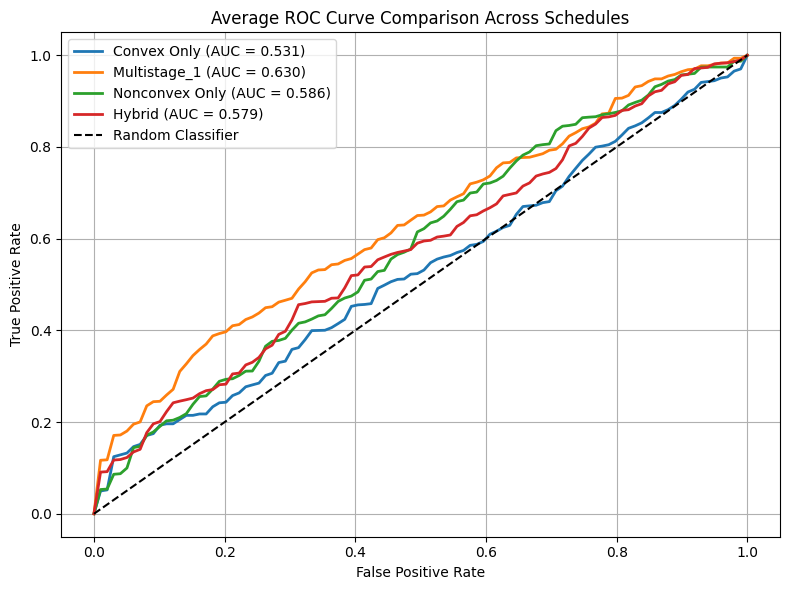

In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from tensorflow.keras.metrics import Precision, Recall, AUC
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
shap_feature_importance = {}


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from sklearn.utils import class_weight




import tensorflow as tf
import tensorflow.keras.backend as K

class NoisyLossWrapper(tf.keras.losses.Loss):
    def __init__(self, base_loss_fn, noise_scale=0.5, name='noisy_loss'):
        super(NoisyLossWrapper, self).__init__(name=name)
        self.base_loss_fn = base_loss_fn
        self.noise_scale = noise_scale

    def call(self, y_true, y_pred):
        base_loss = self.base_loss_fn(y_true, y_pred)
        noise = tf.random.normal(shape=tf.shape(base_loss), mean=0.3, stddev=self.noise_scale) # make noise 0
        return base_loss + noise



def model_builder_convex():
    model = tf.keras.Sequential([
        
        # Handle padded sequences
        tf.keras.layers.Masking(
            mask_value=0.0,
            input_shape=(X_filtered.shape[1], X_filtered.shape[2])
        ),

        # Convex-compatible LSTM (tanh + sigmoid only)
        tf.keras.layers.LSTM(
            32,
            activation='tanh',              # smooth, convex-friendly
            recurrent_activation='sigmoid', # safe gating
            return_sequences=False
        ),

        # Convex dense layers
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='softplus'),
                # Extra non-convex expressiveness
        tf.keras.layers.Dense(32, activation='softplus'),

        # Output (sigmoid for BCE)
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model





def model_builder_nonconvex():
    model = tf.keras.Sequential([
        # Handles padded sequences safely
        tf.keras.layers.Masking(
            mask_value=0.0,
            input_shape=(X_filtered.shape[1], X_filtered.shape[2])
        ),

        # Non-convex temporal extractor
        tf.keras.layers.LSTM(
            32,
            activation='tanh',
            recurrent_activation='sigmoid',
            return_sequences=False,
           # kernel_initializer='glorot_uniform'
        ),

        # Deep non-convex block
        tf.keras.layers.Dense(128, activation='sigmoid'),
        tf.keras.layers.Dense(64, activation='sigmoid'),
        tf.keras.layers.Dense(32, activation='sigmoid'),

        # Extra non-convex expressiveness
        tf.keras.layers.Dense(32, activation='sigmoid'),

        # Output
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model







import tensorflow as tf

class ConvexFocalLoss(tf.keras.losses.Loss):
    """
    Convex-style Focal Loss using convex logistic link (softplus)
    instead of sigmoid. The focal term (1 - p_t)^gamma remains
    dynamic and fully inside the computational graph.
    """
    def __init__(self, gamma=0.5, alpha=0.25,
                 reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE,
                 name='convex_focal_loss'):
        super().__init__(reduction=reduction, name=name)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred_logits):

        # Softplus-based convex logistic components
        pos_term = tf.nn.softplus(-y_pred_logits)  # convex
        neg_term = tf.nn.softplus(y_pred_logits)   # convex

        # Convex surrogate "probability"
        # p = exp(-softplus(-z)) is convex in logits
        p = tf.exp(-pos_term)

        # Class-dependent p_t
        p_t = y_true * p + (1 - y_true) * (1 - p)

        # ---- Convex surrogate for focal weighting ----
        # Original: (1 - p_t)^gamma      → nonconvex
        # New convex surrogate: exp(-gamma * p_t)
        focal_weight = tf.exp(-self.gamma * p_t)   # convex & monotone decreasing

        # Base convex logistic loss
        base_loss = y_true * pos_term + (1 - y_true) * neg_term

        # Weighted convex loss (convex * convex → convex)
        loss = self.alpha * focal_weight * base_loss

        return tf.reduce_mean(loss)




convex_focal_loss_fn = ConvexFocalLoss(gamma=0.0, alpha=0.1)


#convex_focal_loss = NoisyLossWrapper(convex_focal_loss_fn, noise_scale=0.5)
convex_focal_loss=convex_focal_loss_fn
convex_focal_loss.__name__ = "convex_focal_loss"

nonconvex_focal_loss_fn = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=True, alpha=0.25, gamma=4.0, from_logits=False,
    label_smoothing=0.0, axis=-1, reduction='sum_over_batch_size'
)
#nonconvex_focal_loss = NoisyLossWrapper(nonconvex_focal_loss_fn, noise_scale=0.5)
nonconvex_focal_loss = nonconvex_focal_loss_fn
nonconvex_focal_loss.__name__ = "nonconvex_focal_loss"


hybrid_nonconvex_focal_loss_fn = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=True, alpha=0.5, gamma=4.0, from_logits=False,
    label_smoothing=0.0, axis=-1, reduction='sum_over_batch_size'
)
#hybrid_nonconvex_focal_loss = NoisyLossWrapper(hybrid_nonconvex_focal_loss_fn, noise_scale=0.5)
hybrid_nonconvex_focal_loss = hybrid_nonconvex_focal_loss_fn
hybrid_nonconvex_focal_loss.__name__ = "hybrid_nonconvex_focal_loss"



training_schedule_convex = [
    {"loss_fn": convex_focal_loss, "epochs": 100},
]

training_schedule_multistage_1 = [
    {"loss_fn": convex_focal_loss, "epochs": 10},
     {"loss_fn": nonconvex_focal_loss, "epochs":40},
      {"loss_fn": hybrid_nonconvex_focal_loss, "epochs":50},
]

training_schedule_multistage_2 = [
    {"loss_fn": convex_focal_loss, "epochs":10},
    {"loss_fn": nonconvex_focal_loss, "epochs":90},
]


hybrid_training_schedule_nonconvex = [
    {"loss_fn": hybrid_nonconvex_focal_loss, "epochs": 100},
]

training_schedule_nonconvex = [
    {"loss_fn": nonconvex_focal_loss, "epochs": 100},
]


def cross_validate(schedule, schedule_name, X_data, y_data, k_folds=10):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    metrics_list = []
    roc_data = []

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data)):
        print(f"\n📂 Fold {fold + 1}/{k_folds}")

        X_train_fold, X_val_fold = X_data[train_index], X_data[val_index]
        y_train_fold, y_val_fold = y_data[train_index], y_data[val_index]

        result = train_with_schedule_fold(schedule, schedule_name, X_train_fold, y_train_fold, X_val_fold, y_val_fold, fold)
        metrics_list.append(result)
        roc_data.append((result["fpr"], result["tpr"]))

    avg_metrics = {
        "loss": np.mean([m["loss"] for m in metrics_list]),
        "accuracy": np.mean([m["accuracy"] for m in metrics_list]),
        "precision": np.mean([m["precision"] for m in metrics_list]),
        "recall": np.mean([m["recall"] for m in metrics_list]),
        "f1": np.mean([m["f1"] for m in metrics_list]),
        "auc": np.mean([m["auc"] for m in metrics_list]),
    }

    print(f"\n📊 Average metrics for schedule '{schedule_name}': {avg_metrics}")
    return avg_metrics, roc_data


def get_model_type_from_loss(loss_fn):
    name = loss_fn.__name__.lower()

    if name.startswith("convex"):
        return "convex"
    elif name.startswith("nonconvex"):
        return "nonconvex"
    elif name.startswith("hybrid"):
        return "nonconvex"   # hybrid is nonconvex
    else:
        raise ValueError(f"Unknown loss type: {loss_fn.__name__}")




def train_with_schedule_fold(schedule, schedule_name, trainX, trainY, testX, testY, fold_index):
    first_loss = schedule[0]["loss_fn"]
    model_type = get_model_type_from_loss(first_loss)

    if model_type == "convex":
        model = model_builder_convex()
        #print(f"[FOLD {fold_index}] Using CONVEX model for loss: {first_loss.__name__}")

    else:
        model = model_builder_nonconvex()
        #print(f"[FOLD {fold_index}] Using NON-CONVEX model for loss: {first_loss.__name__}")

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.9,
        staircase=True
    )
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
    current_epoch = 0

    for i, stage in enumerate(schedule):
        loss_fn = stage["loss_fn"]
        epochs = stage["epochs"]
        print(f"\n➡️ Stage {i + 1} | Epochs: {epochs} | Loss: {loss_fn.__name__}")

        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
        )

        model.fit(
            trainX, trainY,
            initial_epoch=current_epoch,
            epochs=current_epoch + epochs,
            batch_size=1,
            validation_data=(testX, testY),
            verbose=0
        )
        current_epoch += epochs

    eval_results = model.evaluate(testX, testY, verbose=0)
    y_pred_prob = model.predict(testX, verbose=0).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    f1 = f1_score(testY, y_pred)
    auc_score = roc_auc_score(testY, y_pred_prob)
    fpr, tpr, _ = roc_curve(testY, y_pred_prob)

    # SHAP values for fold 1 only
    if fold_index == 0:
        print(f"🔍 Calculating SHAP values for fold 1 of '{schedule_name}'")
        background = trainX[:100].astype(np.float32)
        test_sample = testX[:100].astype(np.float32)

        # Recompile without metrics for SHAP
        model.compile(optimizer=optimizer, loss=loss_fn)

        explainer = shap.GradientExplainer(model, background)
        shap_values = explainer.shap_values(test_sample)[0]

        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        feature_names = getattr(testX, "columns", [f"Feature {i}" for i in range(testX.shape[1])])
        shap_feature_importance[schedule_name] = dict(zip(feature_names, mean_abs_shap))

    return {
        "loss": eval_results[0],
        "accuracy": eval_results[1],
        "precision": eval_results[2],
        "recall": eval_results[3],
        "auc": auc_score,
        "f1": f1,
        "fpr": fpr,
        "tpr": tpr
    }

def average_roc_curves(roc_data, num_points=100):
    mean_fpr = np.linspace(0, 1, num_points)
    tprs = []

    for fpr, tpr in roc_data:
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    return mean_fpr, mean_tpr, mean_auc

# 🧪 Run experiments and collect metrics
results_cv = {}
roc_data_schedules = {}


results_cv["Convex Only"], roc_data_schedules["Convex Only"] = cross_validate(training_schedule_convex, "Convex Only", X_resampled, y_resampled)
results_cv["Multistage_1"], roc_data_schedules["Multistage_1"] = cross_validate(training_schedule_multistage_1, "Multistage_1", X_resampled, y_resampled)
results_cv["Nonconvex Only"], roc_data_schedules["Nonconvex Only"] = cross_validate(training_schedule_nonconvex, "Nonconvex Only", X_resampled, y_resampled)
results_cv["Hybrid"], roc_data_schedules["Hybrid"] = cross_validate(hybrid_training_schedule_nonconvex, "Hybrid", X_resampled, y_resampled)
#results_cv["Multistage_2"], roc_data_schedules["Multistage_2"] = cross_validate(training_schedule_multistage_2, "Multistage_2", X_resampled, y_resampled)


# 📤 Export metrics to CSV
results_df = pd.DataFrame.from_dict(results_cv, orient='index')
results_df.to_csv("cross_validation_results_2.csv", index_label="Schedule")
print("✅ Metrics exported to 'cross_validation_results_2.csv'")

# 📊 Plot average ROC curves
plt.figure(figsize=(8, 6))
for name, data in roc_data_schedules.items():
    fpr, tpr, auc_val = average_roc_curves(data)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {auc_val:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("Average ROC Curve Comparison Across Schedules")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# 📊 SHAP Comparison Bar Plot
shap_df = pd.DataFrame(shap_feature_importance).fillna(0)
#shap_df["mean"] = shap_df.mean(axis=1)
shap_df
shap_df.to_csv("cross_validation_shap_2.csv", index_label="Schedule")

#shap_df = shap_df.sort_values("mean", ascending=True)
#shap_df.drop("mean", axis=1, inplace=True)


In [18]:
import numpy as np
import pandas as pd

# Suppose shap_feature_importance is a dict of lists or arrays
shap_df = pd.DataFrame(shap_feature_importance).fillna(0)

# Flatten array entries
shap_df = shap_df.applymap(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)

# Now compute row-wise mean
shap_df["mean"] = shap_df.mean(axis=1, numeric_only=True)

# Save
shap_df.to_csv("cross_validation_shap_2.csv", index_label="Schedule")
shap_df.head()



/var/folders/ql/5nmrkn3145n9_pzr7h7w7_gh0000gn/T/ipykernel_54300/4213904531.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  shap_df = shap_df.applymap(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)


,Convex Only,Multistage_1,Nonconvex Only,Hybrid,mean
Feature 0,8.506446e-06,3.655996e-09,7.473508e-09,3.250318e-06,2.941973e-06
Feature 1,1.825639e-02,2.995637e-05,7.982672e-05,1.811474e-02,9.120227e-03
Feature 2,1.054912e-10,1.550555e-11,1.637865e-11,3.213247e-07,8.036553e-08
Feature 3,1.177089e-03,1.597574e-07,1.481216e-07,9.857793e-05,3.189937e-04
Feature 4,2.169371e-04,8.499424e-05,6.340352e-04,1.444492e-04,2.701039e-04


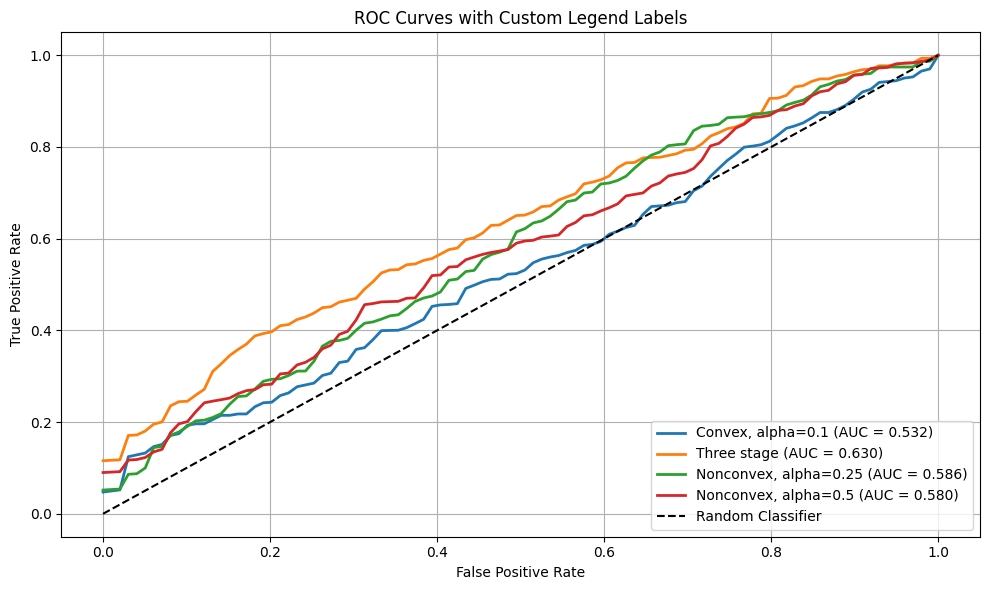

✅ Saved:
 - roc_custom_legend.png (ROC plot)
 - roc_summary_results.csv (AUC summary)
 - roc_curve_points.csv (All FPR–TPR points)


,Schedule,Label,AUC
0,Convex Only,"Convex, alpha=0.1",0.531695
1,Multistage_1,Three stage,0.630347
2,Nonconvex Only,"Nonconvex, alpha=0.25",0.586044
3,Hybrid,"Nonconvex, alpha=0.5",0.580044


,Schedule,FPR,TPR
0,Convex Only,0.000000,0.047472
1,Convex Only,0.010101,0.049798
2,Convex Only,0.020202,0.052125
3,Convex Only,0.030303,0.124563
4,Convex Only,0.040404,0.128513


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# === Function to compute average ROC curve ===
def average_roc_curves(roc_data_list):
    """
    roc_data_list: list of tuples [(fpr, tpr)] or [(fpr, tpr, auc_val)]
    Returns averaged fpr, tpr, and mean AUC
    """
    fpr_grid = np.linspace(0, 1, 100)
    tpr_interp = []
    auc_vals = []

    for entry in roc_data_list:
        # Handle 2-tuple or 3-tuple gracefully
        if len(entry) == 2:
            fpr, tpr = entry
        elif len(entry) == 3:
            fpr, tpr, _ = entry
        else:
            raise ValueError(f"Unexpected ROC entry shape: {entry}")
        tpr_interp.append(np.interp(fpr_grid, fpr, tpr))
        auc_vals.append(auc(fpr, tpr))

    mean_tpr = np.mean(tpr_interp, axis=0)
    mean_auc = np.mean(auc_vals)
    return fpr_grid, mean_tpr, mean_auc


# === Plot ROC curves ===
selected_schedules = ["Convex Only", "Multistage_1", "Nonconvex Only", "Hybrid"]
legend_labels = {
    "Convex Only": "Convex, alpha=0.1",
    "Multistage_1": "Three stage",
    "Nonconvex Only": "Nonconvex, alpha=0.25",
    "Hybrid": "Nonconvex, alpha=0.5",
   # "Multistage_2": "Two stage",
}

results = []
roc_points = []  # store all averaged ROC points

plt.figure(figsize=(10, 6))
for schedule in selected_schedules:
    if schedule in roc_data_schedules:
        fpr, tpr, auc_val = average_roc_curves(roc_data_schedules[schedule])
        label = f"{legend_labels.get(schedule, schedule)} (AUC = {auc_val:.3f})"
        plt.plot(fpr, tpr, lw=2, label=label)

        # Summary results
        results.append({
            "Schedule": schedule,
            "Label": legend_labels.get(schedule, schedule),
            "AUC": auc_val
        })

        # Store every (fpr, tpr) point
        for i in range(len(fpr)):
            roc_points.append({
                "Schedule": schedule,
                "FPR": fpr[i],
                "TPR": tpr[i]
            })
    else:
        print(f"⚠️ Warning: No ROC data for '{schedule}'")

# === Plot styling ===
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves with Custom Legend Labels")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# === Save figure and data ===
plt.savefig("roc_custom_legend.png", dpi=300)
plt.show()

# Save AUC summary
roc_summary = pd.DataFrame(results)
roc_summary.to_csv("roc_summary_results.csv", index=False)

# Save all ROC points
roc_points_df = pd.DataFrame(roc_points)
roc_points_df.to_csv("roc_curve_points.csv", index=False)

print("✅ Saved:")
print(" - roc_custom_legend.png (ROC plot)")
print(" - roc_summary_results.csv (AUC summary)")
print(" - roc_curve_points.csv (All FPR–TPR points)")
display(roc_summary.head())
display(roc_points_df.head())


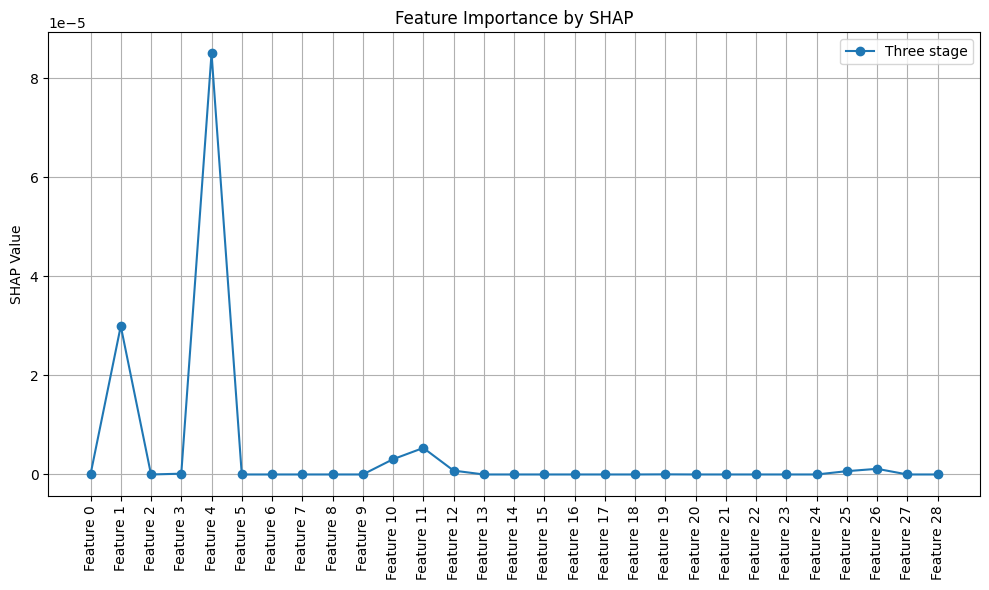

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# === Load and preprocess the SHAP file ===
shap_df = pd.read_csv("cross_validation_shap_2.csv")
shap_df.columns = shap_df.columns.str.strip()

# Convert SHAP value strings to floats
for col in shap_df.columns[1:]:
    shap_df[col] = shap_df[col].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x)

# === Step 1: Define original and custom legend names ===
selected_schedules = ["Multistage_1"]
legend_labels = {
    #"Convex Only": "Convex, alpha=0.1",
    "Multistage_1": "Three stage",
   # "Nonconvex Only": "Nonconvex, alpha=0.25",
   # "Hybrid": "Nonconvex, alpha=0.5",
    #"Multistage_2": "Two stage",
}

# === Step 2: Plot each schedule with a custom label ===
plt.figure(figsize=(10, 6))
for schedule in selected_schedules:
    if schedule in shap_df.columns:
        plt.plot(shap_df["Schedule"], shap_df[schedule], marker='o', label=legend_labels.get(schedule, schedule))
    else:
        print(f"Warning: Schedule '{schedule}' not found.")

plt.xticks(rotation=90)
plt.ylabel("SHAP Value")
plt.title("Feature Importance by SHAP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("shap_plot_custom_legend.png")
plt.show()
